# Obtaining Relative Diffusivity Curves

This is an example of calculating relative diffusivity in OpenPNM. The term **relative** indicates the existence of another phase in the medium. The concept of relative property (permeability) in multiphase transport was applied in relative permeability example for a flow problem. In this example the transport mechanism is defined as diffusion. 

In [13]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
op.visualization.set_mpl_style()
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

## Create network and phases

First, we create a network and assign phases and properties in a similar way that we used to do for the other examples. Note that `op.models.collections.phase` is added to assign fluid properties such as diffusivity, surface tension, etc, and `op.models.collections.physics` is added to assign pore-scale models such as entry pressure, conduit conductance. Surface tension info will be used in Invasion percolation in the next step. Here, we assumed a user-defined value for air surface tension and contact angle, as they are not included in `collections.phase.air`. Similarly, a user-defined value for water diffusivity was assumed, as it is not included in `collections.phase.water`.

In [14]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=1e-6)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water['pore.diffusivity'] = 1e-9
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()

## Apply ordinary percolation

To simulate a partially saturated material we first invade some non-wetting phase.  This will be accomplished using the ``InvasonPercolation`` or ``OrdinaryPercolation`` algorithm. In both algorithms the invading phase invades the network based on the capillary pressure of the throats in the network. These two algorithms have difference in their percolation algorithm and results. As Invasion percolation was implemented in the relative permeability example, here we choose ordinary percolation to demonstrate how we can use its results. It is assumed that the invading phase is water:

In [15]:
drn = op.algorithms.Drainage(network=pn, phase=water)
drn.set_inlet_BC(pn.pores('left'))
drn.run()

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

In ordinary percolation, occupancies and saturation can be extracted from the results for a capillary pressure point. For example:

In [16]:
water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
air['pore.occupancy'] = 1 - water['pore.occupancy']
air['throat.occupancy'] = 1 - water['throat.occupancy']

## Saturation and rate functions

To update calculate the saturation based on occupancy from each pressure point, we created a costum function:

In [17]:
def sat_update(network, nwp, wp):
    r"""
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
    """
    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

Similar to the relative permeability example, the geometrical parameters in relative diffusivity can cancell out. Therefore,  the remaining fraction includes diffusion rates as follows:

$$
D_{r}=\frac {D_\text{eff-multiphase}}{D_\text{eff-single phase}}=\frac {Rate_\text{multiphase}}{Rate_\text{single phase}}
$$

Where $Rate_\text{multiphase}$ is the inlet diffusion rate of the phase (water/air) for a Fickian diffusion algorithm with `multiphase conduit_conductance` assigned as conduit diffusive conductance model to account for the existence of the other phase. Whereas $Rate_\text{single phase}$ is the inlet diffusion rate of the phase (water/air) for a Fickian diffusion algorithm with `generic_diffusive_conductance` assigned as diffusive conductance model for a single phase flow.


Note that $D_\text{eff-single phase}$ is a property of the porous material, not the fluid. However, here to cancel out diffusivity in the $D_{r}$ fraction, the same phase must be used to calculate $Rate_\text{single phase}$. Therefore, we only need to find the rate values for calcuating the relative permeability.
We define a function `Rate_calc`, which simulates a Fickian diffusion given the diffusive conductance keyword and returns the rate diffusion at inlet pores. 

In [18]:
def Rate_calc(network, phase, inlet, outlet, conductance):
        phase.regenerate_models()
        Fd = op.algorithms.FickianDiffusion(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val

In this example we are focusing on finding the relative diffusivities in x direction. A similar procedure can be applied on y and z directions. Let's define inlet and outlet pores:

In [19]:
diff_in = pn.pores('left')
diff_out = pn.pores('right')

## Define multiphase conductance

Similar to the relative permeability example, multiphase conductance models are assigned to account for the presence of the other phase:

In [20]:
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')

## Calculate relative diffusivities

Now that we have defined the required models and functions, we can find the relative diffusivity of phases over a range of saturation. The saturation points are found at a range of invasion pressure:

In [21]:
Snwparr = []
reldiff_nwp = []
reldiff_wp = []
for Pc in np.unique(drn['pore.invasion_pressure']):
    water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    air.regenerate_models()
    water.regenerate_models()
    sat_point = sat_update(pn, water, air)
    Snwparr.append(sat_point)
    Rate_single_nwp = Rate_calc(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_single_wp = Rate_calc(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_mult_nwp = Rate_calc(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    Rate_mult_wp = Rate_calc(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
    reldiff_wp.append(Rate_mult_wp/Rate_single_wp)

Plotting the curves:

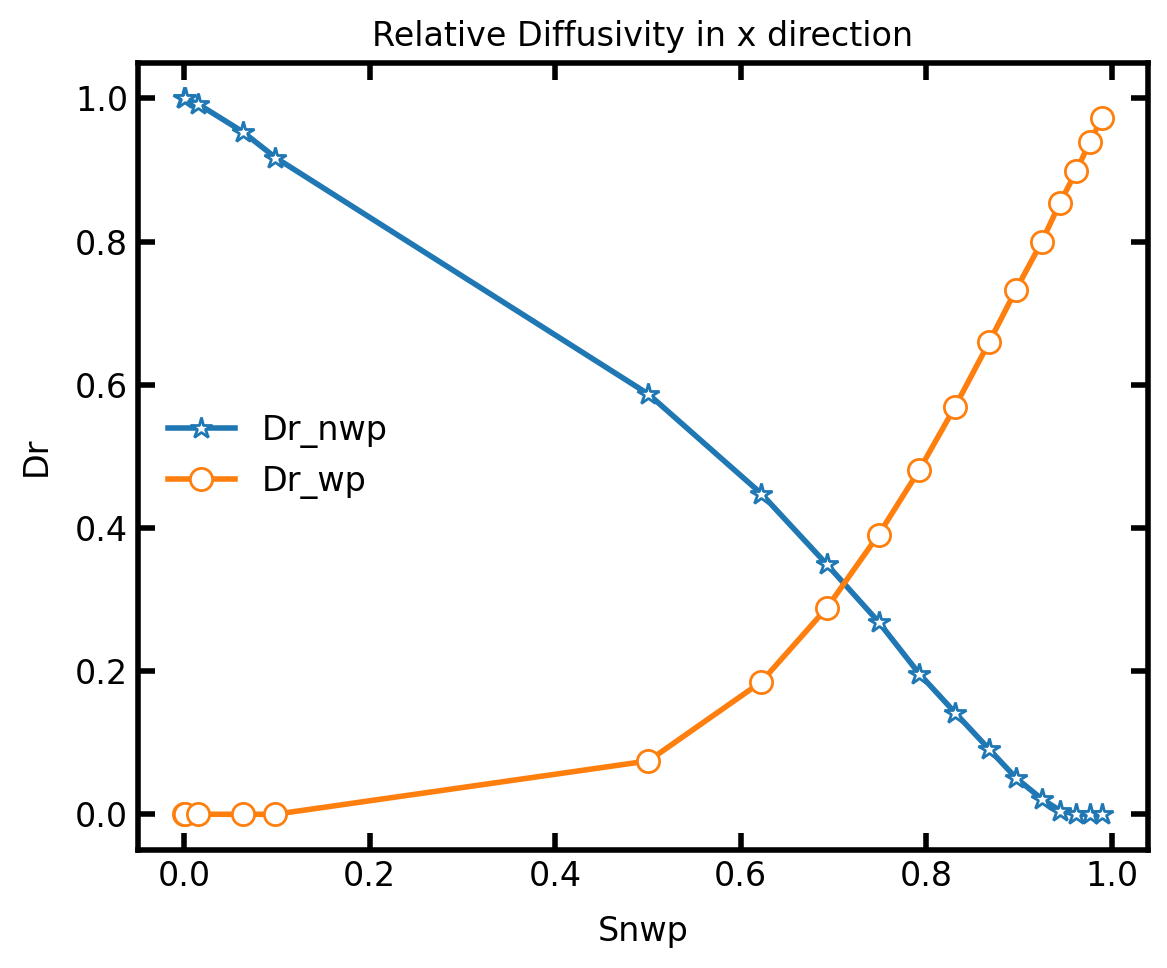

In [22]:
plt.figure(figsize=[6,5])
plt.plot(Snwparr, reldiff_nwp, '*-', label='Dr_nwp')
plt.plot(Snwparr, reldiff_wp, 'o-', label='Dr_wp')
plt.xlabel('Snwp')
plt.ylabel('Dr')
plt.title('Relative Diffusivity in x direction')
plt.legend()